# Electricity Demand Forecasting

## Time Series Modeling

In this project I am exploring time series modeling for Electricity Demand Forecasting
for the state of California.  

This file reads a datafile that was created using the Python scripts eai_query.py and 
add_census.py.  The primary data is collected from eia.gov and contains electricity demand
on an hourly basis from July, 2015 to February, 2020.  After reading the datafile the
cells in this notebook simply split the dataset into a training subset and a validation subset.

## <table id='Table_Of_Contents'>Table Of Contents</table>

1. [Import Modules](#import)<br>
2. [Read Data File](#read_data)<br>
    2A. [Clean Data Frame](#clean_data)<br>
    2B. [Data Split](#data_split)<br>
3. [Helper Function](#helper)<br>
4. [Data Analysis](#analysis)<br>
    4A. [Stationarity Testing](#stationarity)<br>
    4B. [Autocorrelation](#autocorr)<br>
    4C. [Seasonal Decomposition](#seasonal_decomp)<br>
5. [Data Aggregation](#data_agg)<br>
    




### <a id='import'> 1. Import Modules</a>

In [30]:
import pandas as pd
import numpy as np
import re

import json
import datetime


from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse


import warnings

from dateutil import parser

import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.statespace.mlemodel

### <a id='read_data'>2. Data Import </a>

In [31]:
data_file = '../data/big_demand_temp.csv'

In [32]:
full_df = pd.read_csv(data_file, index_col=0).astype({'demand':'float'})

#### 2.1 Clean the data frame <a id='clean_data'></a>

Make the time column a standard Datetime object and then drop the time column.  Next we create a date column that does not contain the time portion of the entry.  The date column will be used for data aggregation later.  Finally, I create a Day Of Week Category and one hot encode the days of the week.


In [33]:
# Convert the time string to a datetime object
dt_time = [parser.isoparse(x) for x in full_df.loc[:, 'time']]
full_df.index = pd.DatetimeIndex(dt_time)
full_df.drop('time', axis=1, inplace=True)
full_df.sort_index(inplace=True)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41114 entries, 2015-07-01 08:00:00+00:00 to 2020-03-09 14:00:00+00:00
Data columns (total 8 columns):
demand           41114 non-null float64
Los Angeles      41114 non-null float64
San Diego        41114 non-null float64
San Jose         41114 non-null float64
San Francisco    41114 non-null float64
Sacramento       41114 non-null float64
Fresno           41114 non-null float64
CA_pop           41114 non-null float64
dtypes: float64(8)
memory usage: 2.8 MB


In [34]:
full_df.index = pd.DatetimeIndex(full_df.index)
full_df['date'] = [x.date() for x in full_df.index]

#### Extending Exogenous Regressors To Include Day Of Week

In [35]:
days = [x.weekday() for x in full_df.index]
days_df = pd.get_dummies(days)
days_df.columns=['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
days_df['DOW'] = days
days_df.index = full_df.index
new_df = pd.concat([full_df, days_df], axis=1)
col_names = []
col_names.extend(full_df.columns)
col_names.extend(days_df.columns)
new_df.columns = col_names

#### <a id='data_split'>2.B Data Split </a>

In [36]:
# Split the data frame into two parts
data_len = new_df.shape[0]
train_len = int(0.5 * data_len)
window_len = int(0.1 * data_len)
validation_len = int(0.8 * data_len)

In [37]:
# Future notebooks will work better if we split the dataset at the beginning of the week
print(new_df.index[validation_len])
# work backward throug the list until we find DOW == 6
for idx, date in enumerate(new_df.index[validation_len::-1]) :
    if new_df.loc[date, 'DOW'] == 6 :
        break

validation_len = validation_len - idx + 1

2019-04-02 00:00:00+00:00


In [38]:
# Make the primary train/validation split
X_train = new_df.iloc[:validation_len, :]
X_val = new_df.iloc[validation_len:, :]


In [39]:
X_train.tail()

demand  Los Angeles  San Diego  San Jose  \
2019-03-31 19:00:00+00:00  21782.0        78.14      76.39     66.93   
2019-03-31 20:00:00+00:00  21851.0        81.11      79.76     69.05   
2019-03-31 21:00:00+00:00  21960.0        81.93      78.97     72.43   
2019-03-31 22:00:00+00:00  22742.0        82.54      77.68     74.24   
2019-03-31 23:00:00+00:00  23027.0        82.41      76.83     74.12   

                           San Francisco  Sacramento  Fresno      CA_pop  \
2019-03-31 19:00:00+00:00          60.40       61.51   63.82  14173349.0   
2019-03-31 20:00:00+00:00          62.56       64.24   67.47  14173349.0   
2019-03-31 21:00:00+00:00          66.71       67.20   70.13  14173349.0   
2019-03-31 22:00:00+00:00          67.60       70.43   72.52  14173349.0   
2019-03-31 23:00:00+00:00          68.53       72.14   74.41  14173349.0   

                                 date  Mon  Tue  Wed  Thur  Fri  Sat  Sun  DOW  
2019-03-31 19:00:00+00:00  2019-03-31    0    0    0     0    0    0    1    6  
2019-03-31 20:00:00+00:00  2019-03-31    0    0    0     0    0    0    1    6  
2019-03-31 21:00:00+00:00  2019-03-31    0    0    0     0    0    0    1    6  
2019-03-31 22:00:00+00:00  2019-03-31    0    0    0     0    0    0    1    6  
2019-03-31 23:00:00+00:00  2019-03-31    0    0    0     0    0    0    1    6

In [40]:
X_val.head()

demand  Los Angeles  San Diego  San Jose  \
2019-04-01 00:00:00+00:00  24233.0        81.03      76.26     73.87   
2019-04-01 01:00:00+00:00  25377.0        77.71      73.92     71.25   
2019-04-01 02:00:00+00:00  25263.0        74.85      71.90     68.08   
2019-04-01 03:00:00+00:00  26855.0        71.74      70.20     64.87   
2019-04-01 04:00:00+00:00  26907.0        70.26      69.32     61.56   

                           San Francisco  Sacramento  Fresno      CA_pop  \
2019-04-01 00:00:00+00:00          65.30       73.42   75.23  14173349.0   
2019-04-01 01:00:00+00:00          62.63       73.58   74.98  14173349.0   
2019-04-01 02:00:00+00:00          60.05       73.29   73.82  14173349.0   
2019-04-01 03:00:00+00:00          58.02       64.46   71.32  14173349.0   
2019-04-01 04:00:00+00:00          57.41       67.34   67.98  14173349.0   

                                 date  Mon  Tue  Wed  Thur  Fri  Sat  Sun  DOW  
2019-04-01 00:00:00+00:00  2019-04-01    1    0    0     0    0    0    0    0  
2019-04-01 01:00:00+00:00  2019-04-01    1    0    0     0    0    0    0    0  
2019-04-01 02:00:00+00:00  2019-04-01    1    0    0     0    0    0    0    0  
2019-04-01 03:00:00+00:00  2019-04-01    1    0    0     0    0    0    0    0  
2019-04-01 04:00:00+00:00  2019-04-01    1    0    0     0    0    0    0    0

In [41]:
# Save the test data to a csv file
X_val.to_csv('../data/big_demand_temp_validation.csv')
X_train.to_csv('../data/big_demand_temp_train.csv')

In [42]:
# Look at the dataframe contents
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32867 entries, 2015-07-01 08:00:00+00:00 to 2019-03-31 23:00:00+00:00
Data columns (total 17 columns):
demand           32867 non-null float64
Los Angeles      32867 non-null float64
San Diego        32867 non-null float64
San Jose         32867 non-null float64
San Francisco    32867 non-null float64
Sacramento       32867 non-null float64
Fresno           32867 non-null float64
CA_pop           32867 non-null float64
date             32867 non-null object
Mon              32867 non-null uint8
Tue              32867 non-null uint8
Wed              32867 non-null uint8
Thur             32867 non-null uint8
Fri              32867 non-null uint8
Sat              32867 non-null uint8
Sun              32867 non-null uint8
DOW              32867 non-null int64
dtypes: float64(8), int64(1), object(1), uint8(7)
memory usage: 3.0+ MB


### <a id='helper'>3. Helper Function </a>

In [43]:
# This funtion tests the stationarity of the data set
#   The function was originally published as part of the Blog post
#
#   https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba
#
#
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

### <a id='analysis'>4. Data Analysis </a>

No handles with labels found to put in legend.


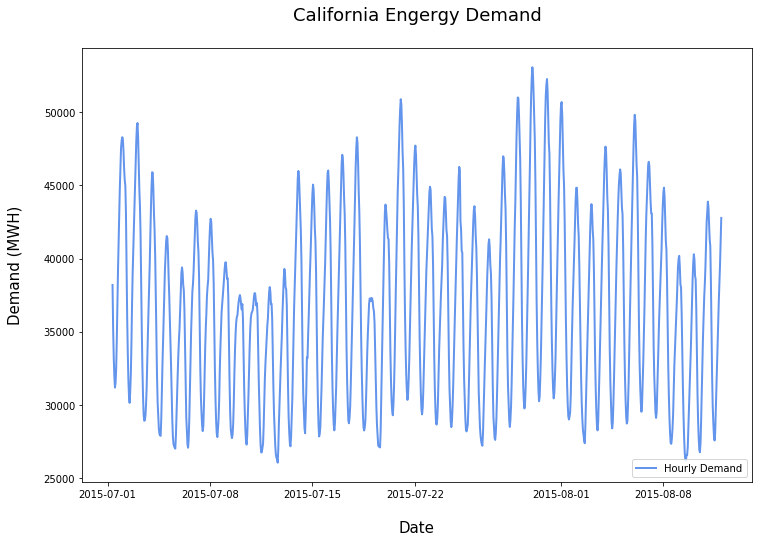

In [44]:
fig = plt.figure(figsize=[12, 8])
fig.patch.set_alpha(0.0)
fig.patch.set_facecolor(None)

ax = fig.add_subplot(1,1,1)
ax.patch.set_visible(False)
ax.set_alpha(0.0)

plt.plot(facecolor=('#000000'), alpha=0.0)


plt.title('California Engergy Demand\n', fontsize=18)
plt.xlabel('\nDate', fontsize=15)
plt.ylabel('Demand (MWH)\n', fontsize=15)
plt.legend(loc='lower right')

plt.plot(X_train.index[:1000], X_train['demand'].values[:1000], \
    c='cornflowerblue', label='Hourly Demand', linewidth=2)

plt.legend( loc='lower right')

plt.savefig('raw_demand_data.png', Transparent=True)

#### <a id='stationarity'>4.1 Stationarity Testing </a>

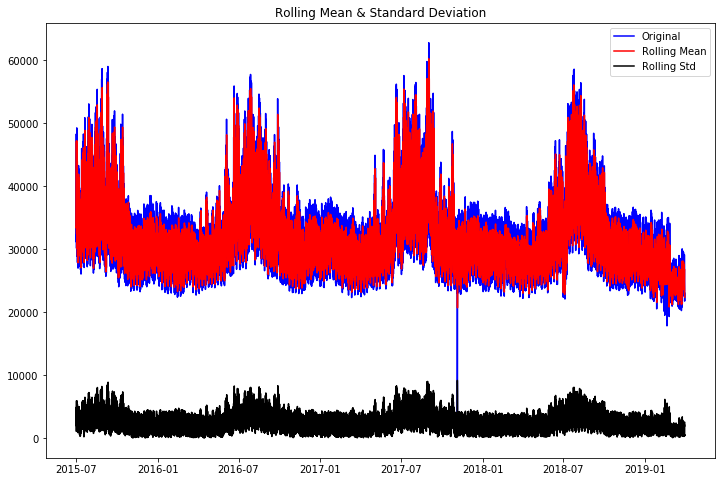

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                    -5.013566
p-value                            0.000021
#Lags Used                        20.000000
Number of Observations Used    32846.000000
Critical Value (1%)               -3.430549
Critical Value (5%)               -2.861628
Critical Value (10%)              -2.566817
dtype: float64


In [45]:
test_stationarity(X_train.demand, window=8)

#### <a id='autocorr'>4B. Autocorrelation </a>

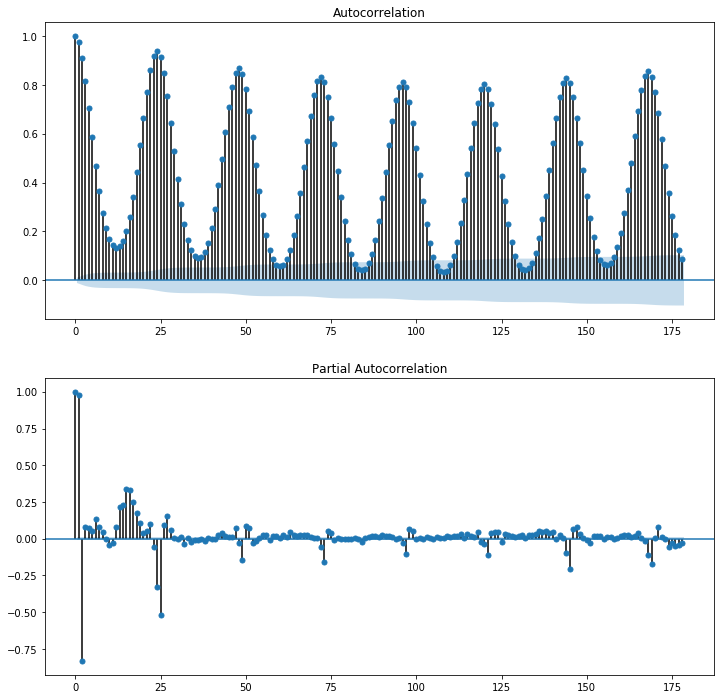

In [46]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X_train['demand'], lags=24*7+10, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(X_train['demand'], lags=24*7+10, ax=ax2)# , lags=40

#### <a id='seasonal_decomp'>4C. Seasonal Decomposition </a>

In [47]:
# Do seasonal decopostion on the weekly periodic features
decomp_data = seasonal_decompose(X_train.demand, period=24, model='additive')

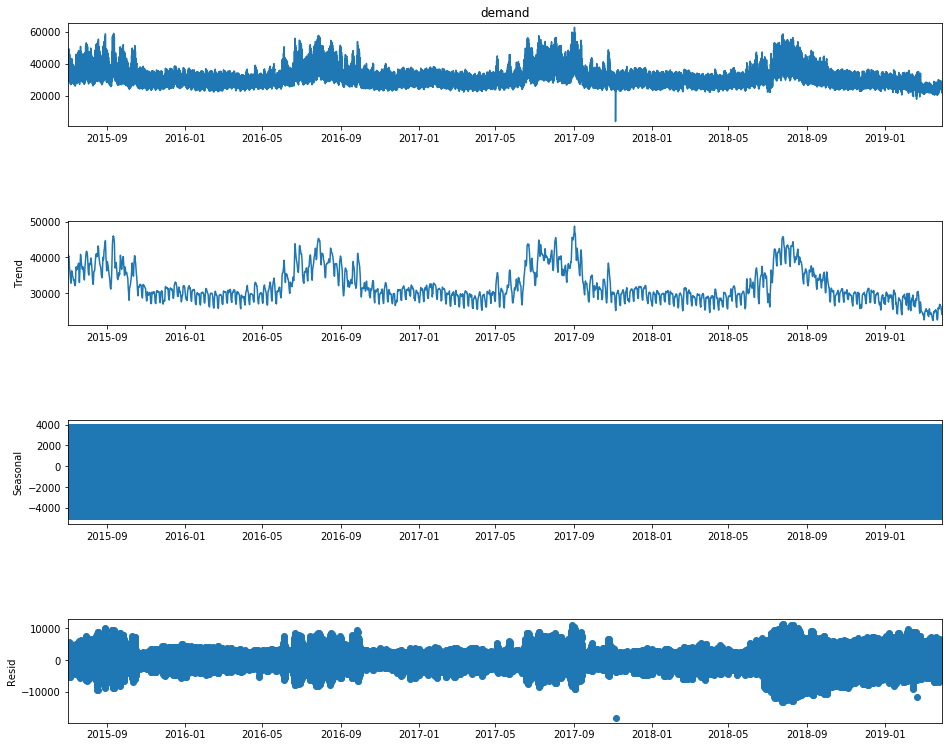

In [48]:
fig = decomp_data.plot()
fig.set_size_inches(15, 12)

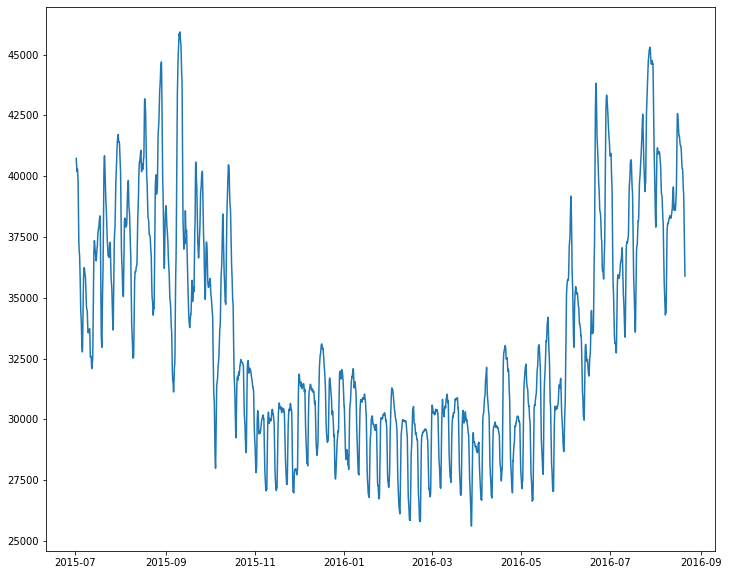

In [49]:
# Plot a closeup of the seasonal component
fig = plt.figure(figsize=[12,10])
plt.plot(decomp_data.trend[:10000])

### <a id='data_agg'>5. Data Aggregation</a>

One of the goals of this project is to forecast one to two weeks in the future if not further out. Forecasting weeks in advance can with hourly demand data can be challenging.  I will aggregate the data by day and week and save
new files for modeling explorations.

In [50]:
def agg_daily(data_frame):
    '''
        Function: agg_daily

        Description: Aggregate the energy demand data on a daily basis.  
        Accumulate the energy demand into a daily total.
        Record the high temperature for each of the cities in the dataset.  
        Then create and return the new dataframe.

        Arguments: data_frame - Pandas dataframe containing the energy demand
            data on an hourly basis.

        Return: Aggregated dataframe with daily demand total and daily high temps.

    '''

    # Create the new dataframe with a single entry for the first day
    current_day = X_train.index[0].date()
    X_by_day = pd.DataFrame([], index=[current_day], \
        columns=['day_demand', 'CA_pop', 'la_high', 'sd_high', 'sj_high', 'sf_high',\
                   'sac_high', 'f_high', 'DOW' ])

    # Initialize the variables used to accumulate daily data
    day_demand = 0.0 
    la_high = 0
    sd_high = 0
    f_high = 0
    sj_high = 0
    sf_high = 0
    sac_high = 0
    pop = 0


    # for each entry in the dataframe
    for row in data_frame.index :

        # Check the date for the next entry
        next_day = row.date()

        # If we're changing days then 
        if next_day != current_day :
            X_by_day.loc[current_day] = [day_demand, pop, la_high, sd_high, sj_high, sf_high, \
                        sac_high, f_high, current_day.weekday()]
            '''
            {'day_demand' :day_demand, 'la_high': la_high,\
                'sd_high' : sd_high, 'f_high' : f_high, 'DOW' : current_day.weekday()}
            '''
            current_day = next_day
            la_high = 0
            sd_high = 0
            sj_high = 0
            sf_high = 0
            sac_high = 0
            f_high = 0
            day_demand = 0
            pop=0

        # Accumulate the demand and test high temperatures.  If this is a new day the
        #  values were reset above.
        day_demand += data_frame.loc[row, 'demand']
        pop = data_frame.loc[row, 'CA_pop']
        if data_frame.loc[row, 'Los Angeles'] > la_high :
            la_high = data_frame.loc[row, 'Los Angeles']
        if data_frame.loc[row, 'San Diego'] > sd_high :
            sd_high = data_frame.loc[row, 'San Diego']
        if data_frame.loc[row, 'Fresno'] > f_high :
            f_high = data_frame.loc[row, 'Fresno']
        if data_frame.loc[row, 'San Jose'] > sj_high :
            sj_high = data_frame.loc[row, 'San Jose']
        if data_frame.loc[row, 'San Francisco'] > sf_high :
            sf_high = data_frame.loc[row, 'San Francisco']
        if data_frame.loc[row, 'Sacramento'] > sac_high :
            sac_high = data_frame.loc[row, 'Sacramento']
    
    # Save the last of the accumulated data
    X_by_day.loc[current_day] = [day_demand, pop, la_high, sd_high, sj_high, sf_high, \
                sac_high, f_high, current_day.weekday()]
    
    # Return the dataframe for the aggregated data.
    return X_by_day

    

In [51]:
X_by_day = agg_daily(X_train)

In [52]:
X_by_day.head()

day_demand       CA_pop la_high sd_high sj_high sf_high sac_high  \
2015-07-01     615661  1.38458e+07   85.78   75.72   92.65   69.25    98.16   
2015-07-02     964443  1.38458e+07   85.37   77.99   85.28   68.23    99.52   
2015-07-03     904339  1.38458e+07   83.46   76.39   83.64   68.14    97.25   
2015-07-04     863264  1.38458e+07   80.62    72.2   83.68   66.28   100.92   
2015-07-05     801034  1.38458e+07   77.41   71.56   82.13   67.46    99.65   

            f_high DOW  
2015-07-01   96.38   2  
2015-07-02   99.75   3  
2015-07-03   99.66   4  
2015-07-04  100.22   5  
2015-07-05  101.26   6

In [53]:
X_by_day.to_csv('../data/big_demand_temp_train_by_day.csv')

In [57]:
def agg_weekly(data_frame) :
    '''
        Function: agg_weekly

        Description: Aggregate the energy demand data on a weekly basis.  
        Accumulate the energy demand into a daily total.
        Record the high temperature for each of the cities in the dataset.  
        Then create and return the new dataframe.

        Arguments: data_frame - Pandas dataframe containing the energy demand
            data on an hourly basis.

        Return: Aggregated dataframe with daily demand total and daily high temps.

    '''

    # Create the new dataframe with a single entry for the first day
    current_day = X_train.index[0].date()

    # Aggregate data on a weekly basis
    current_day = data_frame.index[0].date()
    row = data_frame.index[0]
    current_dow = data_frame.loc[row, 'DOW']
    week_demand = 0.0
    X_by_week = pd.DataFrame([], index=[current_day], \
        columns=['week_demand', 'CA_pop', 'la_high', 'sd_high', 'sj_high', 'sf_high',\
                 'sac_high', 'f_high', 'DOW' ])

    # Initialize the variables used to track high temperatures
    la_high = 0
    sd_high = 0
    f_high = 0
    sj_high = 0
    sf_high = 0
    sac_high = 0
    pop=0
    found_tue = False


    # For each row in the dataframe
    for row in data_frame.index :

        # Check the day of the week
        next_dow = data_frame.loc[row].DOW
        if next_dow == 0 and found_tue == False :
            current_day = row.date()

        if next_dow == 1 :
            found_tue = 1

        # If we've transitioned to the beginning of the next week
        if next_dow == 0 and found_tue :
            # Create an entry for the previous week
            X_by_week.loc[current_day] = [week_demand, pop, \
                la_high, sd_high, sj_high, sf_high, sac_high, f_high, current_day.weekday()]
            '''
            {'day_demand' :day_demand, 'la_high': la_high,\
                'sd_high' : sd_high, 'f_high' : f_high, 'DOW' : current_day.weekday()}
            '''
            current_dow = next_dow
            found_tue = False
            la_high = data_frame.loc[row, 'Los Angeles']
            sd_high = data_frame.loc[row, 'San Diego']
            f_high = data_frame.loc[row, 'Fresno']
            sj_high = data_frame.loc[row, 'San Jose']
            sf_high = data_frame.loc[row, 'San Francisco']
            sac_high = data_frame.loc[row, 'Sacramento']
            pop=0
            week_demand = data_frame.loc[row, 'demand']
        else :
            # If we are still working on the weekly values then adjust as needed.
            week_demand += data_frame.loc[row, 'demand']
            pop = data_frame.loc[row, 'CA_pop']
            if data_frame.loc[row, 'Los Angeles'] > la_high :
                la_high = data_frame.loc[row, 'Los Angeles']
            if data_frame.loc[row, 'San Diego'] > sd_high :
                sd_high = data_frame.loc[row, 'San Diego']
            if data_frame.loc[row, 'Fresno'] > f_high :
                f_high = data_frame.loc[row, 'Fresno']
            if data_frame.loc[row, 'San Francisco'] > sf_high :
                sf_high = data_frame.loc[row, 'San Francisco']
            if data_frame.loc[row, 'San Jose'] > sj_high :
                sj_high = data_frame.loc[row, 'San Jose']
            if data_frame.loc[row, 'Sacramento'] > sac_high :
                sac_high = data_frame.loc[row, 'Sacramento']
                
    X_by_week.loc[current_day] = [week_demand, pop, \
        la_high, sd_high, sj_high, sf_high, sac_high, f_high, current_day.weekday()]

                
    return X_by_week

In [58]:
# Run the weekly aggregation funtion on the training data and check the results
X_train_weekly = agg_weekly(X_train)
X_train_weekly.head(), X_train_weekly.shape

(            week_demand      CA_pop  la_high  sd_high  sj_high  sf_high  \
 2015-07-01          NaN         NaN      NaN      NaN      NaN      NaN   
 2015-07-06    9879836.0  13845790.0    85.78    77.99    92.65    70.22   
 2015-07-13    6105055.0  13845790.0    89.36    84.02    90.26    83.36   
 2015-07-20    6277434.0  13845790.0    87.65    80.50    88.28    78.76   
 2015-07-27    6513309.0  13845790.0    86.55    78.30    95.77    82.20   
 
             sac_high  f_high  DOW  
 2015-07-01       NaN     NaN  NaN  
 2015-07-06    100.92  101.26  0.0  
 2015-07-13     98.36   99.60  0.0  
 2015-07-20     98.36   98.03  0.0  
 2015-07-27    106.58  106.40  0.0  , (196, 9))

In [59]:
# Save the weekly aggregation to a CSV file
X_train_weekly.to_csv('../data/big_demand_temp_train_by_week.csv')